In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Bidirectional, LSTM
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import keras

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
# Load dataset
dataset = pd.read_csv('/kaggle/input/daily-historical-stock-prices-1970-2018/historical_stock_prices.csv', index_col='date', parse_dates=['date'])

In [3]:
# Separate train and test data
train_data = dataset[:'2017'].sort_values(by=['ticker','date'])
test_data = dataset['2018-01-01':'2018-06-30'].sort_values(by=['ticker','date'])

In [4]:
timesteps = 60

In [5]:
# All symbols
symbols = dataset.ticker.unique()

In [6]:
def make_train_set(data,s):
    l = len(data)
    for i in range(timesteps, l):
        x = data[i-timesteps: i, 0]
        y = data[i,0]
        
        x = x.reshape(-1,1)
        y = y.reshape(-1,1)
        
        sc = MinMaxScaler(feature_range=(0,1))
        sc.partial_fit(x)
        sc.partial_fit(y)

        train_set[s]['x'].append(sc.transform(x))
        train_set[s]['y'].append(sc.transform(y))

In [7]:
# Define train_set
train_set = {}
for s in ['A', 'ACER', 'MSFT', 'ABC', 'AAPL']:  
    train_set.update({s:{'x':[],'y':[]}})
    data = train_data.loc[train_data['ticker'] == s][['adj_close']].values
    
    make_train_set(data,s)

In [8]:
# Define earlystopping callback function
es = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, mode='min', restore_best_weights=True)

In [9]:
def make_gru_network():
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    
    regressorGRU.add(GRU(units = 30, return_sequences = False, input_shape=(60,1), activation='tanh'))
    regressorGRU.add(Dropout(0.3))
    
    # The output layer
    regressorGRU.add(Dense(units=1))
    return regressorGRU

In [10]:
# Training multi symbols model
model = make_gru_network()
model.compile(optimizer='rmsprop', loss='mean_squared_error')

n_epoch = 200
x_train = []
y_train = []

for s in train_set:
    print ("Training {}".format(s))
    X_train, Y_train = np.array(train_set[s]['x']), np.array(train_set[s]['y'])
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
    Y_train = Y_train.reshape(Y_train.shape[0])

    print(X_train.shape, Y_train.shape)
    model_history= model.fit(X_train, Y_train, epochs = n_epoch, batch_size = 60, 
                                    validation_split = 0.3,callbacks=[es])

Training A
(4498, 60, 1) (4498,)
Train on 3148 samples, validate on 1350 samples
Epoch 1/200
3148/3148 [==============================] - 4s 1ms/step - loss: 0.1421 - val_loss: 0.0301
Epoch 2/200
3148/3148 [==============================] - 3s 820us/step - loss: 0.0330 - val_loss: 0.0190
Epoch 3/200
3148/3148 [==============================] - 3s 795us/step - loss: 0.0232 - val_loss: 0.0171
Epoch 4/200
3148/3148 [==============================] - 3s 802us/step - loss: 0.0188 - val_loss: 0.0148
Epoch 5/200
3148/3148 [==============================] - 2s 791us/step - loss: 0.0177 - val_loss: 0.0142
Epoch 6/200
3148/3148 [==============================] - 3s 799us/step - loss: 0.0162 - val_loss: 0.0134
Epoch 7/200
3148/3148 [==============================] - 3s 798us/step - loss: 0.0151 - val_loss: 0.0146
Epoch 8/200
3148/3148 [==============================] - 3s 801us/step - loss: 0.0140 - val_loss: 0.0129
Epoch 9/200
3148/3148 [==============================] - 3s 882us/step - loss: 0.

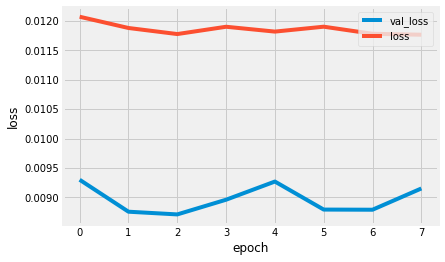

In [11]:
# Plotting validation loss and loss
plt.plot(model_history.history['val_loss'])
plt.plot(model_history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val_loss', 'loss'], loc='upper right')
plt.show()

# Testing method 1

In [12]:
# Test a particular symbol by using Test data
s = "AAPL"
test_adj_close_values = test_data.loc[test_data['ticker'] == s][['adj_close']].values

NameError: name 'testSet' is not defined

In [ ]:
def make_test_set(s, data):
    l = len(data)
    scaler = []
    test_set = {'x':[], 'y':[]}
    y_true = []
    
    for i in range(timesteps, l):
        x = data[i-timesteps: i, 0]
        y = data[i,0]
        y_true.append(y)

        x = x.reshape(-1,1)
        y = y.reshape(-1,1)

        sc = MinMaxScaler(feature_range=(0,1))
        sc.partial_fit(x)
        sc.partial_fit(y)

        scaler.append(sc)

        test_set['x'].append(sc.transform(x))
        test_set['y'].append(sc.transform(y))
        
    return test_set, y_true, scaler

In [ ]:
def make_prediction(s, data):
    test_set, y_true, scaler = make_test_set(s, data)
    X_test = np.array(test_set['x'])
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])
    result = model.predict(X_test)
    y_pred = []
    for i in range(0,len(result)):
        y = result[i]
        y = y.reshape(-1,1)
        k = scaler[i].inverse_transform(y)
        y_pred.append(k[0][0])
    return y_true, y_pred

In [ ]:
y_true, y_pred = make_prediction(s, test_adj_close_values)

In [ ]:
# Plotting actual vs predicted values
plt.plot(y_true, color='green', label='Actual value')
plt.plot(y_pred, color='red', label='Predicted value')
plt.xlabel('Time steps')
plt.ylabel('adj_close value')
plt.title('Ajusted values of {}'.format(s))
plt.show()

# Testing method 2

In [ ]:
# Take 60 real values
test_data_2 = test_adj_close_values[0:60]

In [ ]:
# Make prediction by using predicted values or combination of real values and predicted values
def func(test_data, all_data):
    test_data.reshape(-1,1)
    sc = MinMaxScaler(feature_range=(0,1))
    X_test = np.array(sc.fit_transform(test_data))
    X_test = X_test.reshape(1, X_test.shape[0], X_test.shape[1])
    result = model.predict(X_test)
    for i in range(0,len(result)):
        y = result[i]
        y = y.reshape(-1,1)
        k = sc.inverse_transform(y)
        y_pred = k[0][0]
        
    all_data.append(y_pred)
    if len(all_data) == len(test_adj_close_values) - timesteps:
        return all_data
    else:
        new_test_data = np.append(np.delete(test_data,0), [y_pred]).reshape(-1,1)
        return func(new_test_data, all_data)

In [ ]:
y_pred_2 = func(test_data_2, [])

# Conclusion

Comparation of predicted values by testing method 1, 2 and actual values

In [ ]:
# Plotting graph
plt.plot(y_pred, color='red', label='Predicted value method 1')
plt.plot(y_pred_2, color='blue', label='Predicted value method 2')
plt.plot(y_true, color='green', label='Actual value')
plt.xlabel('Time steps')
plt.ylabel('adj_close value')
plt.title('Ajusted values of {}'.format(s))
plt.show()